# INTRODUÇÃO
<h1><b>Abordagem alternativa de transformação de dados para input no Autoencoder (ou: Embeddind dos Jsons)</b><h1>
<h2>CNJ Inova - Desafio 2 - Time 4</h2>


Este Notebook apresenta abordagem de vetorização dos jsons da base de dados do CNJ, no Hackathon CNJ Inova. Os outputs (matrizes) podem ser utilziados como uma forma alternativa de entradas para o autoencoder (algoritmo detector de anomalias proposto pelo time). Para isso, é necessário o ajuste dos nós de de entrada da rede para que fique de acordo com os parâmetros de saída da camada de embedding aqui apresentada.

Esta abordagem baseia-se na técnica de word2vec, porém aplicada a documentos no formato json. Nesse caso, cada linha representativa de uma inserção de dados ``
millisInsercao`` será interpretada como uma string de texto, antes passando por consideráveis transofmrações. A variabilidade de categorias e combinações possíveis de termos nos documentos faz inferir a possibilidade do tratamento das linhas de inserção como texto, já que as possibilidades de combinações textuais são também bastante grandes. Essas linhas podem, então, ser vetorizadas como assim seria feito no caso de texto.

Dentre algumas vantagens dessa abordagem, cita-se a consolidação enquanto método de vetorização de textos em bom volume de problemas envolvendo processamento de linguagem natural, por isso mostrando-se uma técnica com boas bases teóricas e práticas.

Na seção seguinte, explicamos as diferenças entre as técncias de vetorização, bem como os porquês de estarmos sugerindo esta como uma alternativa.

#EMBEDDING <i>VS</i> OUTRAS TÉCNICAS

Algoritmos de Machine Learning efetuam cálculos utilizando vetores ou escalares. Quando se quer analisar texto, por exemplo, é impraticável dar como input para um modelo as palavras contidas no texto. Para contornar esse problema, utiliza-se técnicas de vetorização de palavras. Vetorizar uma palavra é nada mais que atribuir-lhe um número que lhe representará no conjunto de valavras (cahamado "vocabulário"). A seguir, exploraremos a mecânica básica das principais técnicas , conforme descritas <a href="https://www.tensorflow.org/tutorials/text/word_embeddings?hl=pt-br">neste artigo</a>.

<h3><b>One-hot encoding:</b></h3>
Palavras podem ser interpretadas como variáveis categóricas, cuja aparição ou ausência em um texto pode ser marcada com `True` ou `False` (0 ou 1), respectivamente. Para o problema proposto, considere uma linha do arquivo Json transformada na seguinte `string`: 

```
assunto principal False codigoNacional 7687 numero 05011736320088020010 dataAjuizamento 579783600000 classeProcessual 39 nivelSigilo 0 orgaoJulgador nomeOrgao Foro Colônia Leopoldina
```
Observe que removemos os caracteres especiais, tais como as chaves `{}`, colchetes `[]` e pontuações. Essa remoção é necessária pois esses caracteres não agregarão informação relevente ao vocabulário. Um passo adicional seria a remoção dos equivalentes às "stopwords", que, nessse caso, são equivalentes às keys de cada dicionário (ou labels de colunas). Chaves primárias (ou "quase-primárias") também perdem relevância, à medida que aumentam o tamanho do vocabulário em relação diretamente proporcional ao número de linhas, então, precisam ser removidas. Valores contendo textos com espaço, como o exemplo de "Foro Colônia Leopoldina" precisam ser unidos pois referem-se a uma categoria de foro, como se fossem uma palavra única que lhe identifica.

Nesse caso, o vetor "limpo" de palvras, convertidas todas para letras minúsculas, passa a ser:

```
['false', '7687', '05011736320088020010', '579783600000', '39', '0', 'colônialeopoldina']
```
A abordagem One-hot Encoding endereça cada uma a uma posição, e atribui o valor `1` se a palavra aparece em determinada linha de texto e `0` se ela não aparece. Se as palavras do vetor acima se mantivessem nessa ordem para o endereçamento, uma entrada textual de outra linha do Json contendo novamente a palavra "colônialeopoldina" seria representado pelo seguinte vetor binário:
```
[0,0,0,0,0,0,1]
```
Considerando o tamanho possível de um vocabulário de palavras necessário para representar todas as possibilidades de termos contidos nos processos, fica clara a ineficência dessa eficácia. Imaginemos um total de 10000 palavras no vocabulário, significa que para cada palavra haveria um vetor com 9999 zeros e apenas 1 um.

<h3><b>Palavras como inteiros:</b></h3>
Uma outra técnica viável é a atribuição de um inteiro diferente para cada palavra, o que eliminaria o problema anterior. O problema com esta abordagem está na arbitrariedade (ou não-aleatoriedade) de escolha dos inteiros, que cria viés de peso inicial para os termos da rede.

<h3><b>Embeddings de palavras:</b></h3>
Embeddings de palavras, por outro lado, atribuem inteiros de forma aleatória para as palavras, e depois as transformam em floating points através de um processo de aprendizagem. 

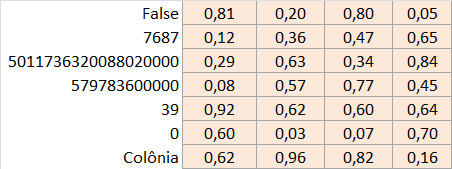

Essa abordagem cria vetores densos, multidimensionais, onde a primeira dimensão representa as linha de texto, e a segunda contêm os vetores que representam cada palavra.

<h3><b>Motivação:</b></h3>
A sugestão dessa abordagem se deu pela verificação da possibilidade de atingimento de maiores taxas de aprendizagem ao informar essa entrada para a rede. No entando, questões estruturais de processamento e tempo inviabilizaram ciclos de treino mais completos e efetivos. Isso não significa que esta é uma abordagem melhor do que aquela escolhida para vetorizar os Jsons no back-end do nosso aplicativo.

#TRATAMENTO DOS DADOS

In [2]:
#Bibliotecas Necessarias:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Os arquivos da base de dados foram hospedados no Google Drive de um dos participantes, de forma que a célula abaixo poderá ser inativada ou excluída dependendo da localização dos arquivos do leitor deste Notebook.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


A variabilidade entre esferas da justiça resulta em padrões de processos diferentes. Asssim, é fundamental segmentar a base de dados antes das implementações conforme a divisão inferida das pastas. A função abaixo recebe o path da pasta de nome 'base' (diertório-pai de todas as outras subpastas de dados disponibilizados) e uma lista contendo "nomes" das esferças de justiça, e cria listas de localizações de arquivos por cada esfera.

In [4]:
def create_jus_list(base_path, jus_name):
  import os

  _base_paths = []
  __base_paths = []
  jus_list = []

  for e in os.listdir(base_path):
    if jus_name in e:
      jus_path = base_path + '/' + e
  for ee in os.listdir(jus_path):
    __path = jus_path + '/' + ee
    if os.path.isdir(__path):
      for eee in os.listdir(__path):
        ___path = jus_path + '/' + ee + '/' + eee
        if os.path.isfile(___path) and ___path.endswith('.json'):
          jus_list.append(___path)
  return jus_list

jus_list = ['eleitoral', 'estadual', 'federal', 'militar', 'trabalho', 'superiores']
files_paths_dict = {}

for jus in jus_list:
  files_paths_dict[jus] = create_jus_list('/content/drive/My Drive/Hackathon_CNJ/base', jus)

Vamos começar com um arquivo contendo todos os processos do TJAL...

In [5]:
raw_data = pd.DataFrame()
for f in files_paths_dict['estadual']:
  if 'tjal' in f:
    raw_data = raw_data.append(pd.read_json(f))

raw_data.head()

,millisInsercao,dadosBasicos,siglaTribunal,movimento,grau
0,1509763311404,"{'assunto': [{'principal': False, 'codigoNacio...",TJAL,"[{'movimentoNacional': {'codigoNacional': 51},...",G1
1,1568779032538,"{'assunto': [{'principal': False, 'codigoNacio...",TJAL,"[{'movimentoNacional': {'codigoNacional': 51},...",G1
2,1542228169485,"{'assunto': [{'principal': False, 'codigoNacio...",TJAL,[{'movimentoNacional': {'codigoNacional': 1061...,G1
3,1501687104516,"{'assunto': [{'principal': False, 'codigoNacio...",TJAL,[{'movimentoNacional': {'codigoNacional': 246}...,G1
4,1528479905040,"{'assunto': [{'principal': False, 'codigoNacio...",TJAL,"[{'movimentoLocal': {'codigoMovimento': 60007,...",G1


As colunas `dadosBasicos` e `movimento` apresentam padrão diferente, com estruturas de listas e/ou dicionários aninhados. Vamos dar uma olhada mais de perto na primeira delas.

In [6]:
#Espiada no formato das linhas de 'dadosBasicos':
for line in raw_data['dadosBasicos'][50:60]:
  print(line)

{'assunto': [{'principal': False, 'codigoNacional': 7687}], 'numero': '05011736320088020010', 'dataAjuizamento': 579783600000, 'classeProcessual': 39, 'nivelSigilo': 0, 'orgaoJulgador': {'nomeOrgao': 'Foro Colônia Leopoldina - Vara do Único Ofício Colônia Leopoldina', 'codigoMunicipioIBGE': 2702108, 'codigoOrgao': '5789', 'instancia': 'ORIG'}, 'codigoLocalidade': '2702108'}
{'assunto': [{'principal': False, 'codigoNacional': 9148}], 'numero': '00045148519888020001', 'dataAjuizamento': 584377200000, 'classeProcessual': 156, 'nivelSigilo': 0, 'orgaoJulgador': {'nomeOrgao': '11ª Vara Cível da Capital', 'codigoMunicipioIBGE': 2704302, 'codigoOrgao': '47', 'instancia': 'ORIG'}, 'codigoLocalidade': '2704302'}
{'assunto': [{'principal': False, 'codigoNacional': 8960}], 'numero': '00049192419888020001', 'dataAjuizamento': 586450800000, 'classeProcessual': 7, 'nivelSigilo': 0, 'orgaoJulgador': {'nomeOrgao': '5ª Vara Cível da Capital', 'codigoMunicipioIBGE': 2704302, 'codigoOrgao': '5', 'instanc

<h2><b>O que não importa:</b></h2>
Podemos verificar que o campo `dadosBasicos` possui muitos subníveis e algumas peculiaridades:

*   Há chaves primárias ou "quase primárias", significando alta variabilidade dessa informação para um vocabulário de palavras.
*   Há muitos termos usados como labels, tais como `assunto`, `principal`, `codigoNacional` etc., e esses termos não têm relevância para aprendizagem baseada em texto: equivalem às <b>stopwords</b>.


<h2><b>Funções para tratamento da coluna 'dadosBasicos':</b></h2>
As funções abaixo criam listas de labels contidas em todas as dimensionalidades dos dados na coluna `dadosBasicos` e fazem remoção de chaves "pseudo-primárias". As listas de labels serão usadas em funções futuras (elas comporão a lista de "stopwords" a serem removidas dos dados).

In [7]:
def pop_pseudo_primary_db(col):
  """
  Remove chaves 'pseudo-primarias' da coluna 'dadosBasicos'
  """
  col.pop('numero')
  col.pop('dataAjuizamento')

def join_words_db(col):
  """
  Faz a junção de palavras em campos com formato de texto contendo espaços para
  a coluna "dadosBasicos"
  """
  col['orgaoJulgador']['nomeOrgao'] = \
  col['orgaoJulgador']['nomeOrgao'].replace(" ", "")

def unique_keys_db(col):
  """
  Itera pelo primeiro nível dimensional de dicionários da coluna "dadosBasicos",
  extraindo deles as keys() e adicionando a um dicionário que relaciona o tipo
  de dado de cada key.
  """
  keys_dict = {}
  basic_types = [int, float, str]
  for i in col:
    for elem in i:
      if elem not in keys_dict:
        keys_dict[elem] = type(i[elem])
      elif (type(keys_dict[elem]) in basic_types)  &  (type(i[elem]) not in basic_types):
        keys_dict.pop(elem)
        keys_dict[elem] = type(i[elem])
  return keys_dict

def unique_subkeys_db(col, key_list):
  """
  Cria listas de chaves únicas por subkeys
  :param col: coluna de dados do dataframe (serie)
  :type col: pandas series
  :param key_: chave na qual pesquisar subchaves únicas
  :type key_list: list
  :return: lista de subchaves únicas, por chave, por linha da serie
  """
  basic_types = [int, float, str]
  d = {}
  for line in col:
    for key_ in key_list:
      if type(line[key_]) == list:
        for i in range(len(line[key_])):
          for elem in line[key_][i]:
            if not elem in d:
              d[elem] = type(elem)
            elif (type(d[elem]) in basic_types) & (type(elem) not in basic_types):
              d.pop(elem)
              d[elem] = type(elem)
      else:
        for elem in line[key_]:
          if not elem in d:
            d[elem] = type(elem)
          elif (type(d[elem]) in basic_types) & (type(elem) not in basic_types):
            d.pop(elem)
            d[elem] = type(elem)
  return d

<h2><b>Funções para tratamento da coluna 'movimento':</b></h2>
As funções abaixo criam listas de labels contidas em todas as dimensionalidades dos dados na coluna `movimento` e fazem remoção de chaves "pseudo-primárias". As listas de labels serão usadas em funções futuras (elas comporão a lista de "stopwords" a serem removidas dos dados).

In [8]:
def pop_pseudo_primary_mov(col):
  """
  Remove chaves 'pseudo-primarias' da coluna 'movimento'
  """
  if not col is None:
    for elem in col:
      if elem is None:
        continue
      else:
        elem.pop('dataHora')

def unique_keys_mov(col):
  """
  Itera pelo primeiro nível dimensional de dicionários da coluna "movimento",
  extraindo deles as keys() e adicionando a um dicionário que relaciona o tipo
  de dado de cada key.
  """
  basic_types = [int, float, str]
  d = {}
  for i in col:
    if i is None:
      continue
    else:
      for elem in i:
        for elem_ in elem:
          if elem_ not in d:
            d[elem_] = type(elem[elem_])
          elif (type(d[elem_]) in basic_types) & (type(elem[elem_]) not in basic_types):
            d.pop(elem_)
            d[elem_] = type(elem[elem_])
  return d

def unique_subkeys_mov(col, key_list):
  """
  Cria listas de chaves únicas por subkeys para a coluna 'movimento'
  :param col: coluna de dados do dataframe (serie)
  :type col: pandas series
  :param key_: chave na qual pesquisar subchaves únicas
  :type key_list: list
  :return: lista de subchaves únicas, por chave, por linha da serie
  """
  basic_types = [int, float, str]
  d = {}
  for i in col:
    if i is None:
      continue
    else:
      for elem in i:
        for elem_ in elem:
          if elem_ in key_list:
            if type(elem[elem_]) == dict:
              for elem__ in elem[elem_]:
                if elem__ not in d:
                  d[elem__] = type(elem__)
                elif (type(d[elem__]) in basic_types) & (type(elem__) not in basic_types):
                  d.pop(elem__)
                  d[elem__] = type(elem__)
  return d

A função abaixo faz a extração dos nomes e tipos das keys contendo sublabels, sejam elas de quaisquer níveis hierárquicos, valendo para ambas as colunas sendo tratadas nesta etapa.

In [9]:
def keys_w_sublevel(distinct_keys):
  sublevels_key_list = []
  for elem in distinct_keys:
    if distinct_keys[elem] not in [int, float, str]:
      sublevels_key_list.append(elem)
  return sublevels_key_list

Aplicação da função de remoção das "chaves primárias" na coluna 'dadosBasicos' e 'movimento'

In [10]:
raw_data['dadosBasicos'].apply(pop_pseudo_primary_db)
raw_data['dadosBasicos'].apply(join_words_db)
raw_data['movimento'].apply(pop_pseudo_primary_mov)
print(raw_data['dadosBasicos'][0])
print(raw_data['movimento'][0])

0    {'assunto': [{'principal': False, 'codigoNacio...
0    {'assunto': [{'principal': False, 'codigoNacio...
0    {'assunto': [{'principal': False, 'codigoNacio...
0    {'assunto': [{'principal': False, 'assuntoLoca...
0    {'assunto': [{'principal': True, 'assuntoLocal...
0    {'assunto': [{'principal': True, 'assuntoLocal...
0    {'assunto': [{'principal': True, 'assuntoLocal...
0    {'assunto': [{'principal': True, 'assuntoLocal...
0    {'assunto': [{'principal': True, 'codigoNacion...
0    {'assunto': [{'principal': True, 'codigoNacion...
0    {'assunto': [{'principal': True, 'codigoNacion...
0    {'assunto': [{'principal': True, 'codigoNacion...
Name: dadosBasicos, dtype: object
0    [{'movimentoNacional': {'codigoNacional': 51}}...
0    [{'movimentoNacional': {'codigoNacional': 581}...
0    [{'movimentoLocal': {'codigoMovimento': 60007,...
0    [{'movimentoLocal': {'codigoMovimento': 60048,...
0                                                 None
0    [{'movimentoLocal': {'codi

Verificação das dimensões e criação das listas-base para as "stopwords" de 'dadosBasicos' e 'movimento':

In [12]:
uniqueDbKeys_dict = unique_keys_db(raw_data['dadosBasicos'])
uniqueDbKeys_list = list(uniqueDbKeys_dict.keys())
print("Keys distintas em todas as linhas de 'dadosBasicos':")
print(uniqueDbKeys_list, '\n')

dbFatherKeys_list = keys_w_sublevel(uniqueDbKeys_dict)
print("Keys distintas de 'dadosBasicos' que contêm subníveis (sub-dicionários ou sub-listas):")
print(dbFatherKeys_list, '\n')

uniqueDbSubkeys_dict = unique_subkeys_db(raw_data['dadosBasicos'], dbFatherKeys_list)
uniqueDbSubkeys_list = list(uniqueDbSubkeys_dict.keys())
print("Sub-keys distintas em todas as linhas de 'dadosBasicos':")
print(uniqueDbSubkeys_list, '\n')

dbChildKeys_list = keys_w_sublevel(uniqueDbSubkeys_dict)
print("Subkeys distintas de 'dadosBasicos' que contêm subníveis (sub-dicionários ou sub-listas):")
print(dbChildKeys_list)

Keys distintas em todas as linhas de 'dadosBasicos':
['assunto', 'classeProcessual', 'nivelSigilo', 'orgaoJulgador', 'codigoLocalidade', 'totalAssuntos', 'dscSistema', 'procEl'] 

Keys distintas de 'dadosBasicos' que contêm subníveis (sub-dicionários ou sub-listas):
['assunto', 'orgaoJulgador'] 

Sub-keys distintas em todas as linhas de 'dadosBasicos':
['principal', 'codigoNacional', 'nomeOrgao', 'codigoMunicipioIBGE', 'codigoOrgao', 'instancia', 'assuntoLocal', 'codigoAssunto', 'codigoPaiNacional', 'descricao'] 

Subkeys distintas de 'dadosBasicos' que contêm subníveis (sub-dicionários ou sub-listas):
[]


Funções para tratamento de dados da coluna movimento

Remoção das "chaves primárias" da coluna movimento

Verificação das dimensões e criação das listas-base para as "stopwords" da coluna movimento

In [13]:
uniqueMovKeys_dict = unique_keys_mov(raw_data['movimento'])
uniqueMovKeys_list = list(uniqueMovKeys_dict.keys())
print('Keys distintas em todas as linhas:')
print(uniqueMovKeys_list, '\n')

movFatherKeys_list = keys_w_sublevel(uniqueMovKeys_dict)
print('Keys distintas que contém subníveis (sub-dicionários ou sub-listas):')
print(movFatherKeys_list, '\n')

uniqueMovSubkeys_dict = unique_subkeys_mov(raw_data['movimento'], movFatherKeys_list)
uniqueMovSubkeys_list = list(uniqueMovSubkeys_dict.keys())
print('Sub-keys distintas em todas as linhas:')
print(uniqueMovSubkeys_list, '\n')

movChildKeys_list = keys_w_sublevel(uniqueMovSubkeys_dict)
print('Subkeys distintas que contém subníveis (sub-dicionários ou sub-listas):')
print(movChildKeys_list)

Keys distintas em todas as linhas:
['movimentoNacional', 'movimentoLocal', 'orgaoJulgador', 'tipoResponsavelMovimento', 'tipoDecisao'] 

Keys distintas que contém subníveis (sub-dicionários ou sub-listas):
['movimentoNacional', 'movimentoLocal', 'orgaoJulgador'] 

Sub-keys distintas em todas as linhas:
['codigoNacional', 'codigoMovimento', 'codigoPaiNacional', 'nomeOrgao', 'codigoMunicipioIBGE', 'codigoOrgao', 'instancia'] 

Subkeys distintas que contém subníveis (sub-dicionários ou sub-listas):
[]


Transformando as colunas dadosBasicos e movimento em string e combinando-as

In [14]:
def transform_unify(col_A, col_B):
  json_to_str = lambda x: json.dumps(x)
  raw_data_left = col_A.apply(json_to_str)
  raw_data_right = col_B.apply(json_to_str)
  ds = raw_data_left + raw_data_right
  return ds  
  
ds = transform_unify(raw_data['dadosBasicos'], raw_data['movimento'])
ds.head()

0    {"assunto": [{"principal": false, "codigoNacio...
1    {"assunto": [{"principal": false, "codigoNacio...
2    {"assunto": [{"principal": false, "codigoNacio...
3    {"assunto": [{"principal": false, "codigoNacio...
4    {"assunto": [{"principal": false, "codigoNacio...
dtype: object

Remoção de stopwords e caracteres especiais da string combinada

In [15]:
def get_rid(serie, stopwords):
  chars = ',{}:."[]'
  for c in chars:
    serie = serie.apply(lambda x: x.replace(c,''))
  for elem in stopwords:
    serie = serie.apply(lambda x: x.replace(elem,''))
  return serie

def tokenize(row):
  lowercase = row.lower()
  stripped = lowercase.strip()
  splitted = stripped.split()
  return splitted

"Limpeza" do dataset:

In [16]:
ds_cleaned = get_rid(ds, sorted(np.unique(
    uniqueDbKeys_list+uniqueDbSubkeys_list+
    uniqueMovKeys_list+
    uniqueMovSubkeys_list)))

ds_tokenized = list(ds_cleaned.apply(tokenize))
ds_tensor = tf.data.Dataset.from_generator(lambda: ds_tokenized, output_types=tf.string)

Criação do Vocabulário:

In [19]:
vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int')

ds_cleaned_tensor = tf.data.Dataset.from_tensor_slices(ds_cleaned)
vectorize_layer.adapt(ds_cleaned_tensor)

Vetorização (inteiros):

In [20]:
ds_iterate = iter(ds_tensor)

In [22]:
model_int = tf.keras.models.Sequential()
model_int.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_int.add(vectorize_layer)
output_int = model_int.predict(ds_iterate.next())
output_int.resize(output_int.shape[0])
std_output = pad_sequences([output_int],
                           padding='post',
                           truncating='pre',
                           maxlen=300)

Vetorização (floats):

In [23]:
model_float = tf.keras.models.Sequential()
model_float.add(tf.keras.layers.Embedding(vocab_size, 5))
model_float.compile('rmsprop', 'mse')
output_float = model_float.predict(std_output)
output_float.shape

(1, 300, 5)

In [24]:
output_float

array([[[ 0.03969213,  0.04195924,  0.04066813,  0.00392567,
         -0.03958543],
        [ 0.04361856, -0.01788799, -0.0392949 ,  0.0110746 ,
          0.00362981],
        [ 0.00966803,  0.04724664, -0.04864728, -0.00946514,
         -0.0223151 ],
        ...,
        [-0.02748283, -0.04738856, -0.01278005, -0.04724396,
          0.01024581],
        [-0.02748283, -0.04738856, -0.01278005, -0.04724396,
          0.01024581],
        [-0.02748283, -0.04738856, -0.01278005, -0.04724396,
          0.01024581]]], dtype=float32)